In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from preprocessing import load_data,seperate_labels,plot_sk_cm

In [4]:
columnNames, data = load_data('diabetes.csv')
columnNames, xs, ys = seperate_labels(columnNames,data)

In [43]:
print(xs.shape,ys.shape)

(668, 8) (668,)


## Check amount of data missing and whether to impute

In [6]:
print("Zero Data Percentage")
for col in range(len(columnNames)):
    temp = xs[:,col]
    pct_missing = len(temp[temp==0])/len(temp)
    print('{} - {} - {}%'.format(col, columnNames[col], round(pct_missing*100)))

Zero Data Percentage
0 - Pregnancies - 14%
1 - Glucose - 1%
2 - BloodPressure - 4%
3 - SkinThickness - 29%
4 - Insulin - 48%
5 - BMI - 1%
6 - DiabetesPedigreeFunction - 0%
7 - Age - 0%


Pregnancies - 0 value makes sense. no kids<br />
Glucose - even though 1% of values missing, will replace with average<br />
BloodPressure - even though 1% of values missing, will replace with average<br />
SkinThickness - skin thickness being 0 not like, probably missing. will replace with average<br />
Insulin - 48% of insulin values missing doesn't make sense. will replace with average<br />
BMI - even though 1% of values missing, will replace with average<br />
    can further place into overweight/obese categories<br />
DiabetesPedigreeFunction - no missing<br />
Age No values missing<br />

replace 0 values in column 1-5 with mean values<br />

## Visualize data to check for obvious patterns for new features

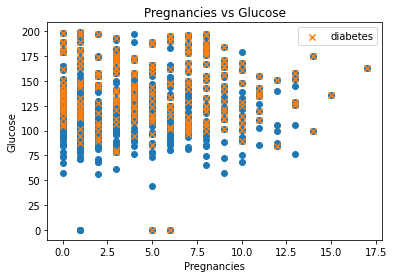

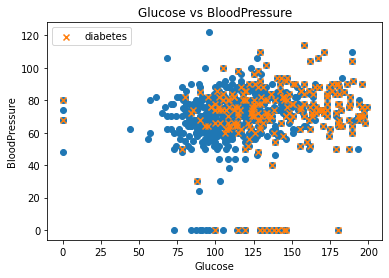

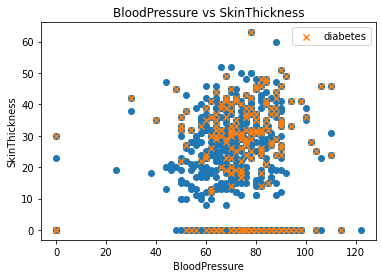

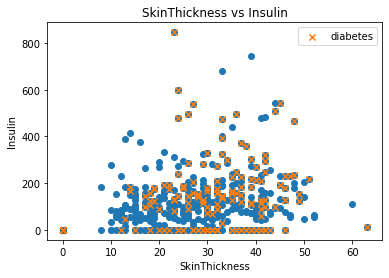

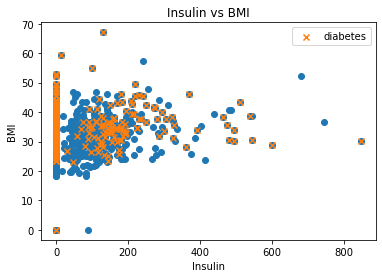

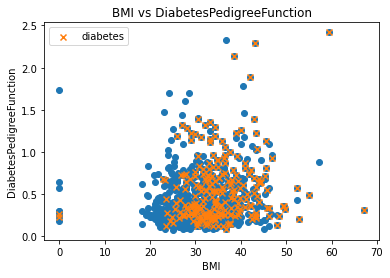

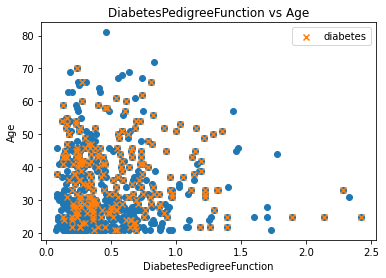

In [7]:
for i in range(len(columnNames)-1):
    plt.figure()
    plt.title("{} vs {}".format(columnNames[i],columnNames[i+1]))
    plt.xlabel(columnNames[i])
    plt.ylabel(columnNames[i+1])
    plt.scatter(xs[:,i],xs[:,i+1],cmap="spring")
    plt.scatter(xs[ys==1,i],xs[ys==1,i+1],label="diabetes",marker='x')
    plt.legend()

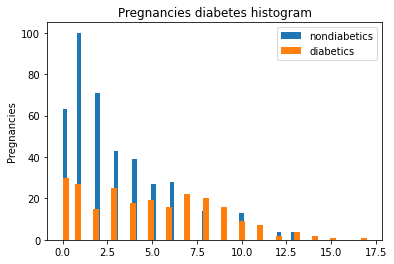

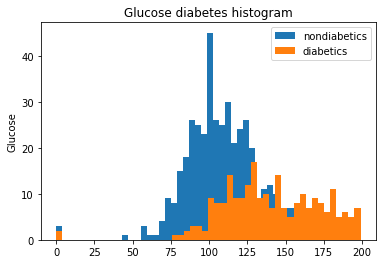

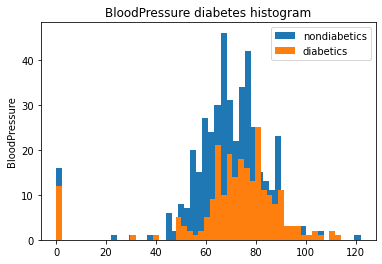

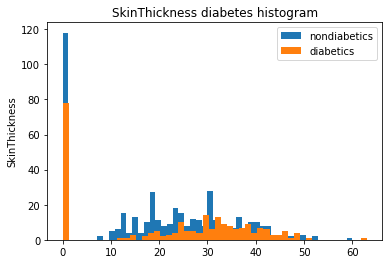

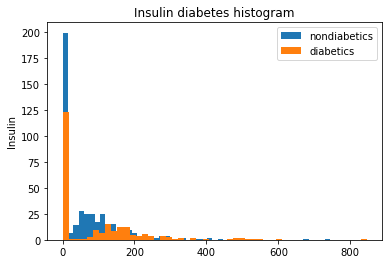

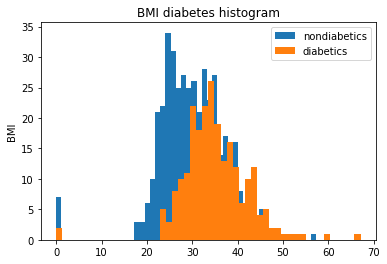

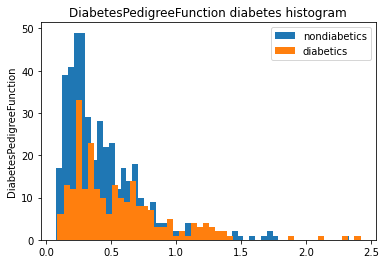

In [8]:
diabeticsxs = xs[ys==1.0,:]
nondiabeticsxs = xs[ys!=1.0,:]

for i in range(len(columnNames)-1):
    plt.figure()
    plt.title("{} diabetes histogram".format(columnNames[i]))
    plt.ylabel(columnNames[i])
    plt.hist(nondiabeticsxs[:,i],bins=50,label = "nondiabetics")
    plt.hist(diabeticsxs[:,i],bins=50,label = "diabetics")
    plt.legend()

## Train Test Split

In [46]:
x_train,x_test,y_train, y_test = train_test_split(xs, ys, test_size = 0.2,random_state=10)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(534, 8) (134, 8)
(534,) (134,)


### Create pipeline to replace missing values and predict new scores

In [44]:
clf= DecisionTreeClassifier(max_depth=3)

In [35]:
t = [('imputer',SimpleImputer(missing_values=0, strategy = 'median'), slice(1,5))]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')
pipe_tree = Pipeline([('Imputer',col_transform),
                 ('Model',DecisionTreeClassifier())])

In [48]:
pipe_tree.fit(x_train,y_train)
scores = cross_val_score(pipe, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
pipe_tree.score(x_test,y_test)

Accuracy: 0.70 (+/- 0.10)


0.6791044776119403

### Mean confusion matrix score across k fold validation 

In [49]:
conf_matrix_list_of_arrays = []
k_fold_test=[]
k_fold_pred=[]
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(x_train,y_train):
    X_ktrain, X_ktest = x_train[train_index], x_train[test_index]
    y_ktrain, y_ktest = y_train[train_index], y_train[test_index]

    pipe_tree.fit(X_ktrain, y_ktrain)
    y_pred = pipe.predict(X_ktest)
    k_fold_test.extend(y_ktest)
    k_fold_pred.extend(y_pred)
    conf_matrix = confusion_matrix(y_ktest, y_pred)
    conf_matrix_list_of_arrays.append(conf_matrix)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)
print(classification_report(k_fold_test,k_fold_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       356
         1.0       1.00      1.00      1.00       178

    accuracy                           1.00       534
   macro avg       1.00      1.00      1.00       534
weighted avg       1.00      1.00      1.00       534



##  Function to plot out score from values calculated 
###
https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

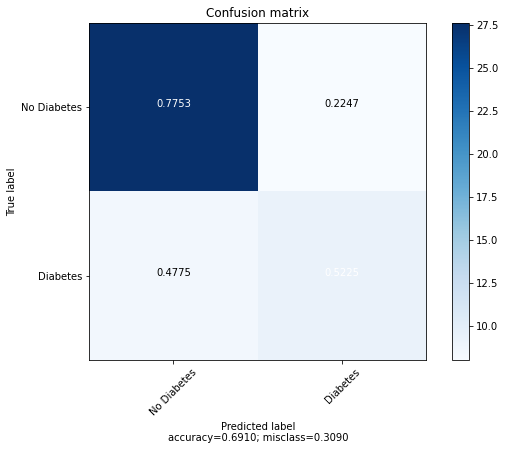

In [33]:
plot_sk_cm(mean_of_conf_matrix_arrays,target_names=['No Diabetes','Diabetes'],name='Decision_Tree_cm')

## Visualising Results 

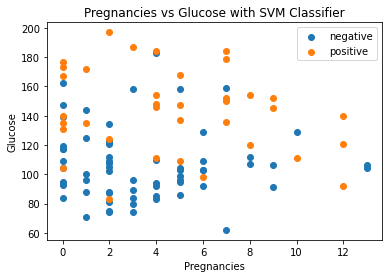

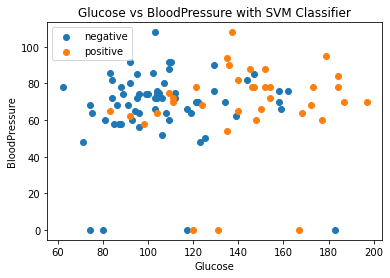

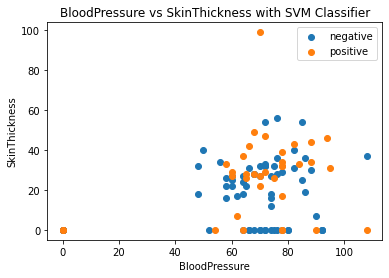

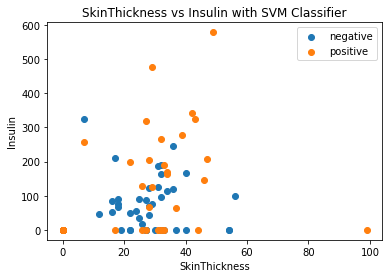

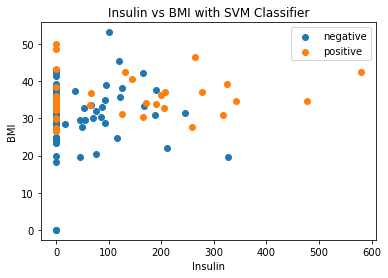

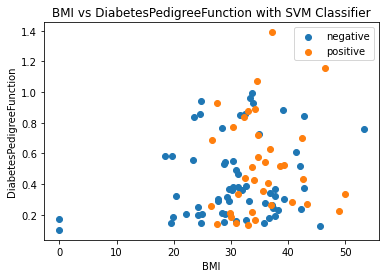

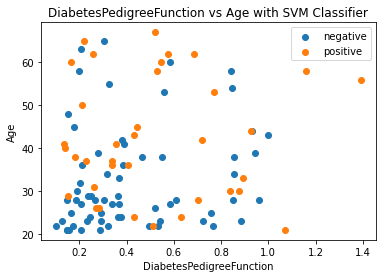

In [42]:
unknown = pd.read_csv('unknowns.csv')
pred=pipe_tree.predict(unknown)
columnNames = unknown.columns
for i in range(len(columnNames)-1):
    fig = plt.figure()
    plt.title("{} vs {} with SVM Classifier".format(columnNames[i],columnNames[i+1]))
    plt.xlabel(columnNames[i])
    plt.ylabel(columnNames[i+1])
    plt.scatter(unknown.iloc[pred==0,i],unknown.iloc[pred==0,i+1],label="negative")
    plt.scatter(unknown.iloc[pred==1,i],unknown.iloc[pred==1,i+1],label="positive")
    plt.legend()
    plt.show()